In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_auc_score

from load_data import load_apoe
from clustering_base import NewmanEig, FastGreedy, CommunityLouvian, metric_adj
from model_evaluation import SVC_grid_search, SVC_score, exp_kernel
import time


In [2]:
path = 'UCLA_APOE_matrices/'
data, target, centers = load_apoe('UCLA_APOE_matrices/')

UCLA APOE data shape                   : (55, 110, 110) 
UCLA APOE target variable shape        : (55,)


In [7]:
distances = euclidean_distances(centers)

In [8]:
weighted_data = np.nan_to_num(data / distances)
binarized_data = data.copy()
binarized_data[data > 0] = 1

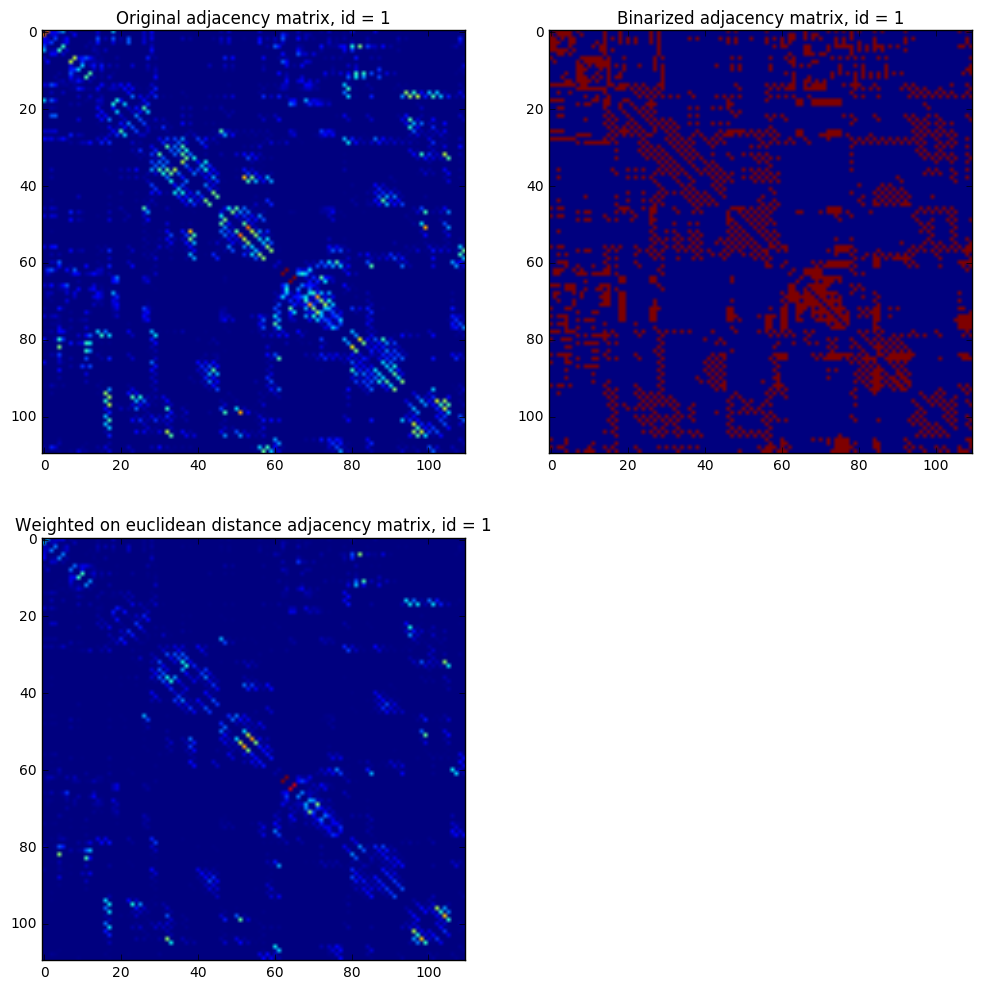

In [9]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(data[1], )
plt.title('Original adjacency matrix, id = 1')
plt.subplot(2,2,2)
plt.imshow(binarized_data[1], )
plt.title('Binarized adjacency matrix, id = 1')
plt.subplot(2,2,3)
plt.imshow(weighted_data[1], )
plt.title('Weighted on euclidean distance adjacency matrix, id = 1',)# fontsize = 12)

In [10]:
partition_w_ne = NewmanEig(weighted_data)
partition_b_ne = NewmanEig(binarized_data)

partition_w_fg = FastGreedy(weighted_data)
partition_b_fg = FastGreedy(binarized_data)

partition_w_l  = CommunityLouvian(weighted_data)
partition_b_l  = CommunityLouvian(binarized_data)

In [11]:
names = ['newman_w', 'newman_b', 'fastgreedy_w', 'fastgreedy_b', 'louvain_w', 'louvain_b']
partitions = [partition_w_ne, partition_b_ne, partition_w_fg, partition_b_fg, partition_w_l, partition_b_l ]
partitions = dict(zip(names, partitions))

In [20]:
ari, ami = {}, {}

for alg, part in partitions.items():
    start = time.time()
    ari[alg], ami[alg] = metric_adj(part, mode='both')
    #print(alg, '{:3f}'.format(time.time() - start))

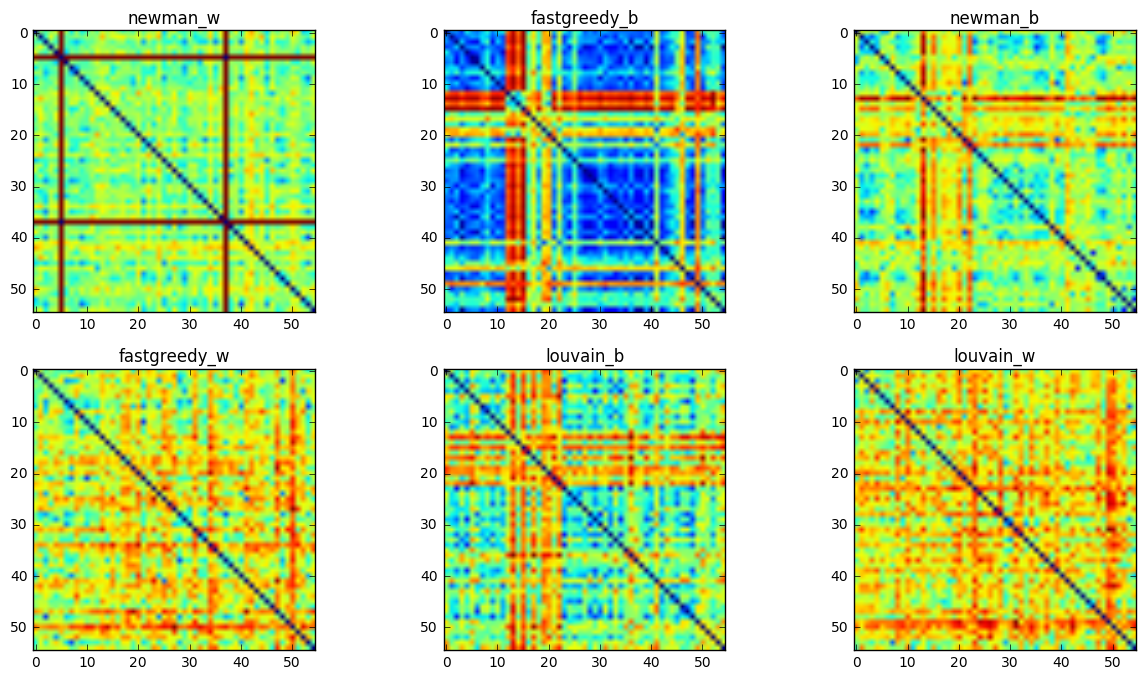

In [21]:
plt.figure(figsize=(15,8))
i = 1
#kernel = np.zeros((55, 55))
for alg, sim in ari.items():
    plt.subplot(2, 3, i)
    i += 1
    plt.imshow(1 - sim)
    plt.title(alg)
    #kernel += (1 - sim)**2

In [10]:
from sklearn.cross_validation import StratifiedKFold
from sklearn import svm

/home/anvar/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
def repeatSVM(gram_matrix, target_vector, n_folds=10,
             n_repetitions=50, penalty=1, LOO=False):
    '''
    This function computes ROC AUC values of SVM with precomputed
    kernel over several runs of k-fold cross-validation

    Accepts:
    gram_matrix - precomputed Gram matrix
    target_vector - target vector of class labels
    n_folds - number of folds for cross-validation
    n_repetitions - number of repetitions of k-fold
                   cross-validation procedure (with random splitting into folds)
    penalty - parameter C of the sklearn.svm.SVC
             (penalty parameter of the error term)
    Returns:
    roc_auc - list of length n_repetitions wherein each
             value is a ROC AUC based on aggregated over folds prediction.
    decisions - list of length n_repetitions wherein each element
               is an array of the respective aggragated outputs of
               the decision function
    Note: decision function output is used for prediction
         to avoid problems with Platt calibration in SVM predict_proba
    '''
    X, y = gram_matrix, np.array(target_vector)
    clf = svm.SVC(C=penalty, kernel='precomputed', random_state=0)
    overall_roc_auc = []
    overall_decisions = []
    # overall_predict_proba = []
    overall_predict = np.zeros(55)

    roc_c = []

    for rep in range(0, n_repetitions):
        if LOO is not True:
            CV = StratifiedKFold(target_vector, n_folds,
                                shuffle=True, random_state=rep)
        else:
            CV = LeaveOneOut(y.shape[0])
        decision_predicted = np.zeros(y.shape[0])
        metrics_dict = {'ROC curve': []}
        for train, test in CV:
            clf.fit(X[train][:, train], y[train])
            decision_output = clf.decision_function(X[test][:, train])
            decision_predicted[test] = decision_output
            # predicted_proba = clf.predicted_proba(X[test][:, train])
            predicted = clf.predict(X[test][:, train])

            #metrics_dict['ROC curve'].append(
            #    roc_curve(y[test], decision_output))
            #roc_c.append(metrics_dict)

        roc_auc_value = roc_auc_score(y, decision_predicted)
        overall_roc_auc.append(roc_auc_value)
        overall_decisions.append(decision_predicted)
        # overall_predict_proba.append(predicted_proba)
        overall_predict[test] = predicted
    # , np.array(overall_predict_proba)
    return np.array(overall_roc_auc), np.array(overall_decisions), np.array(overall_predict)#, roc_c


In [15]:
params = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9] + list(range(1, 15))
penalties = [0.1, 1, 5, 10, 50]

for param in params:
    for penalty in penalties:
        kernel = exp_kernel(ari['louvain_w'], param)
        auc, _, _ = repeatSVM(kernel, target, penalty = penalty)
        print('Kernel parameter : {}, SVM parameter : {}, resulting auc :{:3f} +- {:3f}'.format(
                param, penalty, auc.mean(), auc.std()))

Kernel parameter : 0.01, SVM parameter : 0.1, resulting auc :0.598187 +- 0.026138
Kernel parameter : 0.01, SVM parameter : 1, resulting auc :0.596987 +- 0.026043
Kernel parameter : 0.01, SVM parameter : 5, resulting auc :0.595733 +- 0.025119
Kernel parameter : 0.01, SVM parameter : 10, resulting auc :0.595760 +- 0.024927
Kernel parameter : 0.01, SVM parameter : 50, resulting auc :0.595707 +- 0.024973
Kernel parameter : 0.1, SVM parameter : 0.1, resulting auc :0.598400 +- 0.025328
Kernel parameter : 0.1, SVM parameter : 1, resulting auc :0.597120 +- 0.024921
Kernel parameter : 0.1, SVM parameter : 5, resulting auc :0.597067 +- 0.024715
Kernel parameter : 0.1, SVM parameter : 10, resulting auc :0.597307 +- 0.024715
Kernel parameter : 0.1, SVM parameter : 50, resulting auc :0.579413 +- 0.032071
Kernel parameter : 0.3, SVM parameter : 0.1, resulting auc :0.600133 +- 0.025129
Kernel parameter : 0.3, SVM parameter : 1, resulting auc :0.599733 +- 0.024722
Kernel parameter : 0.3, SVM parameter

In [13]:
kernel = exp_kernel(ari['louvain_w'], 8)
auc, dec, pred = repeatSVM(kernel, target,n_repetitions=100, penalty = 5)

In [14]:
auc.mean()

0.69192000000000009

In [55]:
# params = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9] + list(range(1, 11))
# penalties = [0.1, 1, 5, 10, 50]

# res_ari = {}
# res_ami = {}

# for alg, sim in ari.items():

#     best_params, _, _ =  SVC_grid_search(ari[alg], target, range(55),
#                                          5, params, penalties, random_state = 100)
    
#     res_ari[alg] = SVC_score(ari[alg], target, range(55),
#                              param=best_params['Kernel Parameter'],
#                              penalty=best_params['SVC Parameter'], random_state = 100)
    
            
#     print('ARI', alg, 'param = {}, penalty = {}, mean_auc = {:3f}, std_auc = {:3f}'.format(best_params['Kernel Parameter'],
#                                                                                           best_params['SVC Parameter'],
#                                                                                           res_ari[alg].mean(),
#                                                                                           res_ari[alg].std()))
    
#     best_params, _, _ =  SVC_grid_search(ami[alg], target, range(55),
#                                          5, params, penalties, random_state = 100)
    
#     res_ami[alg] = SVC_score(ami[alg], target, range(55),
#                              param=best_params['Kernel Parameter'],
#                              penalty=best_params['SVC Parameter'], random_state = 100)
    
#     print('AMI', alg, 'param = {}, penalty = {}, mean_auc = {:3f}, std_auc = {:3f}'.format(best_params['Kernel Parameter'],
#                                                                                           best_params['SVC Parameter'],
#                                                                                           res_ami[alg].mean(),
#                                                                                           res_ami[alg].std()))
  